<a href="https://colab.research.google.com/github/bcdmodelos/qualificacao-modelscode/blob/main/Modelo-GPR/codigo_modelo_gpr_bodocongo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise por Regressão por Processos Gaussianos para o bairro de Bodocongó

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
%cd /content/drive/MyDrive/Notebooks_Doutorado/base-campina/

!ls

/content/drive/MyDrive/Notebooks_Doutorado/base-campina
dataset_Amazonas_usableData.csv
dataset_Bodocongo_usable.csv
dataset_Brasil_usableData.csv
dataset_CampinaGrande_casos_acumulados_usable.csv
dataset_CampinaGrande_casos_diarios_usable.csv
dataset_CampinaGrande_usableData.csv
dataset_Catole_usable.csv
dataset_Malvinas_usable.csv
dataset_Paraiba_usableData.csv
dataset_Pernambuco_usableData.csv


In [5]:
file_path = "./dataset_Bodocongo_usable.csv"
casosBodocongo = pd.read_csv(file_path, encoding='latin1')
casosBodocongo

,Data,Estado,Cidade,Teste,Resultado,Evolucao,Data PCR,Conclusao,Data Encerramento,Classificacao Final,...,Sexo,Cidade Residencia,Data Nascimento,CEP,Bairro,cum_casos,cep,cep_valido,lat,long
0,2020-04-21,Paraíba,Campina Grande,TESTE RÁPIDO - ANTICORPO,Positivo,Cura,21/4/2020,Concluído,24/8/2020,Confirmado Laboratorial,...,Masculino,Campina Grande,11/12/1971,58.430-440,BODOCONGO,84,58430440,True,-7.222431,-35.917870
1,2020-04-26,Paraíba,João Pessoa,RT-PCR,Positivo,Cura,26/4/2020,Concluído,27/7/2020,Confirmado Laboratorial,...,Feminino,Campina Grande,31/7/1977,58.430-768,BODOCONGO,111,58430768,True,-7.212799,-35.923563
2,2020-05-07,Paraíba,Campina Grande,TESTE RÁPIDO - ANTICORPO,Positivo,Cura,7/5/2020,Concluído,10/8/2020,Confirmado Laboratorial,...,Feminino,Campina Grande,10/9/1961,58.446-000,BODOCONGO,273,58446000,True,-7.229075,-35.880834
3,2020-05-11,Paraíba,Campina Grande,RT-PCR,Positivo,Cura,11/5/2020,Concluído,27/7/2020,Confirmado Laboratorial,...,Feminino,Campina Grande,28/7/1974,58.446-000,BODOCONGO,375,58446000,True,-7.229075,-35.880834
4,2020-05-12,Paraíba,Campina Grande,TESTE RÁPIDO - ANTICORPO,Positivo,Cura,12/5/2020,Concluído,21/5/2020,Confirmado Laboratorial,...,Feminino,Campina Grande,31/10/1976,58.430-410,BODOCONGO,425,58430410,True,-7.221744,-35.917945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,2021-06-23,Paraíba,Campina Grande,TESTE RÁPIDO - ANTÍGENO,Positivo,NaN,23/6/2021,Concluído,NaN,NaN,...,Masculino,Campina Grande,3/11/1981,58.430-360,BODOCONGO,34529,58430360,True,-7.220000,-35.915353
899,2021-06-24,Paraíba,Campina Grande,TESTE RÁPIDO - ANTICORPO,Positivo,NaN,24/6/2021,Concluído,NaN,NaN,...,Masculino,Campina Grande,17/6/1990,58.400-010,BODOCONGO,34556,58400010,True,-7.217840,-35.884345
900,2021-06-27,Paraíba,Campina Grande,TESTE RÁPIDO - ANTÍGENO,Positivo,NaN,27/6/2021,Concluído,NaN,NaN,...,Feminino,Campina Grande,30/4/1983,58.437-800,BODOCONGO,34702,58437800,True,-7.209098,-35.936488
901,2021-06-30,Paraíba,Campina Grande,TESTE RÁPIDO - ANTICORPO,Positivo,NaN,30/6/2021,Concluído,NaN,NaN,...,Masculino,Campina Grande,10/10/1963,58.437-830,BODOCONGO,34841,58437830,True,-7.208242,-35.933931


In [6]:
casosDiariosBodocongo = casosBodocongo['Data'].value_counts(sort=False)
casosAcumuladosBodocongo = casosDiariosBodocongo.cumsum()
casosAcumuladosBodocongo

2020-04-21      1
2020-04-26      2
2020-05-07      3
2020-05-11      4
2020-05-12      5
             ... 
2021-06-22    898
2021-06-23    899
2021-06-24    900
2021-06-27    901
2021-06-30    903
Name: Data, Length: 303, dtype: int64

In [7]:
datasBodocongo = casosBodocongo['Data'].unique()
casosAcumuladosBodocongo = casosAcumuladosBodocongo.tolist()
dfBodocongo = pd.DataFrame(datasBodocongo, columns=['Data'])
dfCasosBodocongo = pd.DataFrame(casosAcumuladosBodocongo, columns=['Casos_Acumulados'])
dfBodocongo['Casos_Acumulados'] = dfCasosBodocongo['Casos_Acumulados']
dfBodocongo

,Data,Casos_Acumulados
0,2020-04-21,1
1,2020-04-26,2
2,2020-05-07,3
3,2020-05-11,4
4,2020-05-12,5
...,...,...
298,2021-06-22,898
299,2021-06-23,899
300,2021-06-24,900
301,2021-06-27,901


# Visualização dos Dataset de número de casos acumulados

Text(0.5, 0, 'Dia')

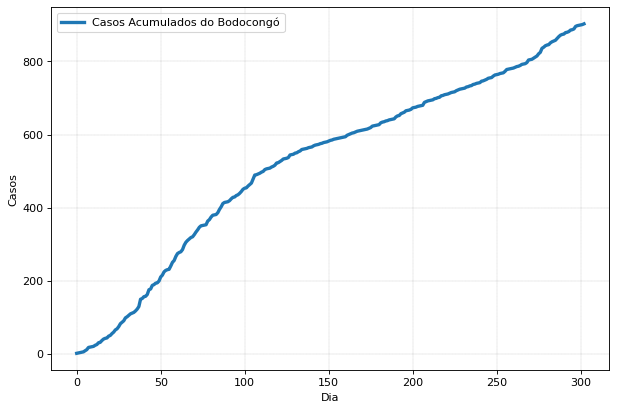

In [8]:
data = np.array(dfBodocongo.Casos_Acumulados.values)
data = data.reshape(-1, 1)

CRdata = data/1000
CRdata  = np.ravel(CRdata)

plt.figure(2, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['Casos Acumulados do Bodocongó'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos')
plt.xlabel('Dia')

Dataset de teste

In [9]:
trainL = len(CRdata) - 30

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]

In [10]:
def half_data(data, time):
    half_data = []
    half_time = []
    for i,item in enumerate(data):
        if i%2 == 0:
            half_data.append(item)
            half_time.append(time[i])

    return np.array(half_data), np.array(half_time)

Modelagem

In [11]:
def GPR_Model(CR_tr, t_tr, CR_test, t_test):

    t = np.append(t_tr, t_test).reshape(-1,1)
    CRdata = np.append(CR_tr, CR_test)

    #kernel = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()
    kernel = ConstantKernel()*RBF()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)
    # kernel = RBF()
    # kernel = Matern()

    model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

    model.fit(t_tr, CR_tr)
    print("\nLearned kernel: %s" % model.kernel_)
    params = model.kernel_.get_params()

    R2_tr  = model.score(t_tr, CR_tr)
    R2     = model.score(t, CRdata)
    R2_test = model.score(t_test, CR_test)

    CRpred_tr, sigma_tr = model.predict(t_tr, return_std=True)
    CRpred_test, sigma_test = model.predict(t_test, return_std=True)
    CRpred, sigma   = model.predict(t, return_std=True)

    MSE = np.mean(((CRpred_tr-CR_tr)*1000)**2)
    print("\nMSE: %f" % MSE)
    print("\nSTD: %f" % np.sqrt(MSE))
    print("\nR2 treinamento: %f" % R2_tr)
    print("\nR2 todo intervalo de dados: %f" % R2)
    print("\nR2 de teste: %f" % R2_test)

    return CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata

In [12]:
CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata = GPR_Model(CR_tr, t_tr, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.0898**2 * RBF(length_scale=1e+05) * DotProduct(sigma_0=1e-05) * 0.0353**2

MSE: 9829.290813

STD: 99.142780

R2 treinamento: 0.826720

R2 todo intervalo de dados: 0.861430

R2 de teste: 0.821686


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [20]:
def plot_gpr(CRdata, CRpred, sigma, t):
    plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    mpl.style.use('default')
    plt.plot(t, CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados Bodocongó')
    plt.axvline(x = t_test[0],linestyle= '--', color = 'black')
    plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)
    plt.fill(np.concatenate([t, t[::-1]]),
            np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                            (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
            alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
    plt.legend(loc='upper left', fontsize = 14)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylabel('Total de casos', fontsize = 14)
    plt.xlabel('dia', fontsize = 14)
    plt.title('COVID-CG Casos Acumulados', fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

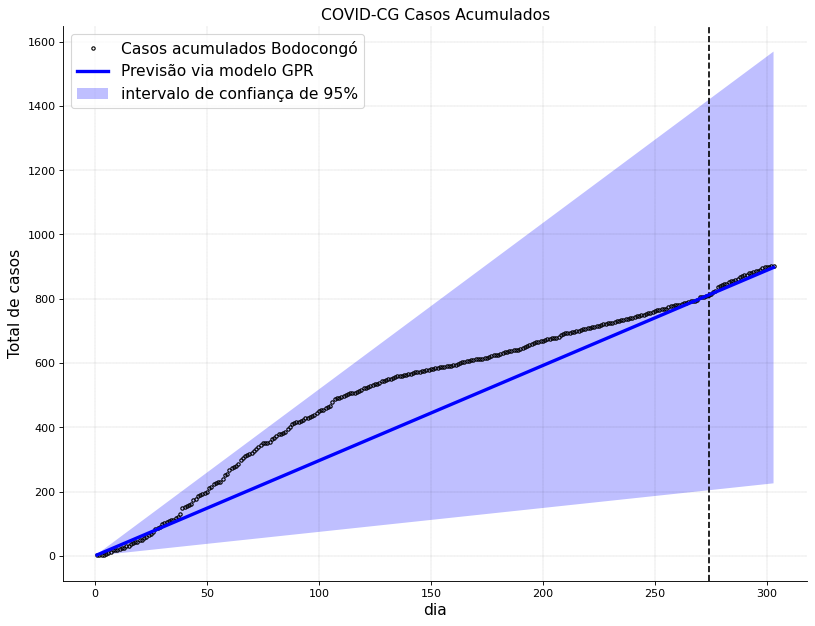

In [22]:
plot_gpr(CRdata, CRpred, sigma, t)

Análise para 50% dos dados

In [23]:
CR_tr_half,t_tr_half = half_data(CR_tr, t_tr)
CRpred_tr_half, sigma_tr_half, CRpred_test_half, sigma_test_half, CRpred_half, sigma_half, t_half, CRdata_half = GPR_Model(CR_tr_half, t_tr_half, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.021**2 * RBF(length_scale=1e+05) * DotProduct(sigma_0=4.81e-05) * 0.139**2

MSE: 23687.425820

STD: 153.907199

R2 treinamento: 0.585556

R2 todo intervalo de dados: 0.667275

R2 de teste: -24.206543


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


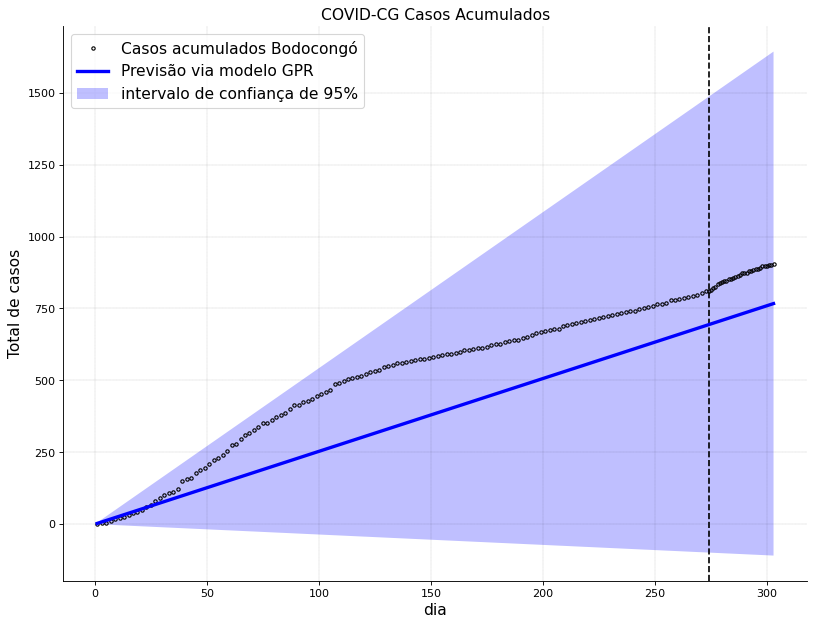

In [24]:
plot_gpr(CRdata_half, CRpred_half, sigma_half, t_half)

Análise para 1/4 dos dados

In [25]:
CR_tr_quarter,t_tr_quarter = half_data(CR_tr_half, t_tr_half)
CRpred_tr_quarter, sigma_tr_quarter, CRpred_test_quarter, sigma_test_quarter, CRpred_quarter, sigma_quarter, t_quarter, CRdata_quarter = GPR_Model(CR_tr_quarter, t_tr_quarter, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.165**2 * RBF(length_scale=5.16e+04) * DotProduct(sigma_0=2.59e-05) * 0.0144**2

MSE: 78097.297074

STD: 279.458936

R2 treinamento: -0.346531

R2 todo intervalo de dados: -0.379439

R2 de teste: -198.660467


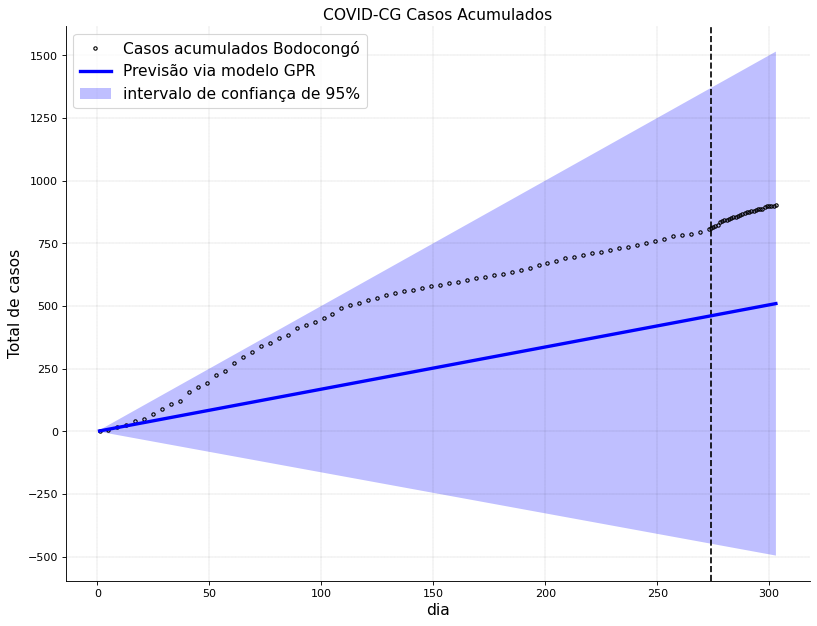

In [26]:
plot_gpr(CRdata_quarter, CRpred_quarter, sigma_quarter, t_quarter)